In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('gold_monthly_csv.csv')
print(df.head())
print(df.tail())

      Date  Price
0  1950-01  34.73
1  1950-02  34.73
2  1950-03  34.73
3  1950-04  34.73
4  1950-05  34.73
        Date     Price
842  2020-03  1593.764
843  2020-04  1680.030
844  2020-05  1715.697
845  2020-06  1734.032
846  2020-07  1840.807


In [22]:
df.shape

(847, 2)

In [23]:
print(df.loc[:, 'Date'][0], "-" ,df.loc[:, 'Date'][846])

1950-01 - 2020-07


In [25]:
date = pd.date_range(start = '1/1/1950', end = '8/1/2020', freq = 'M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [26]:
df['month'] = date
df.drop('Date',  axis = 1, inplace = True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


Text(0, 0.5, 'Price')

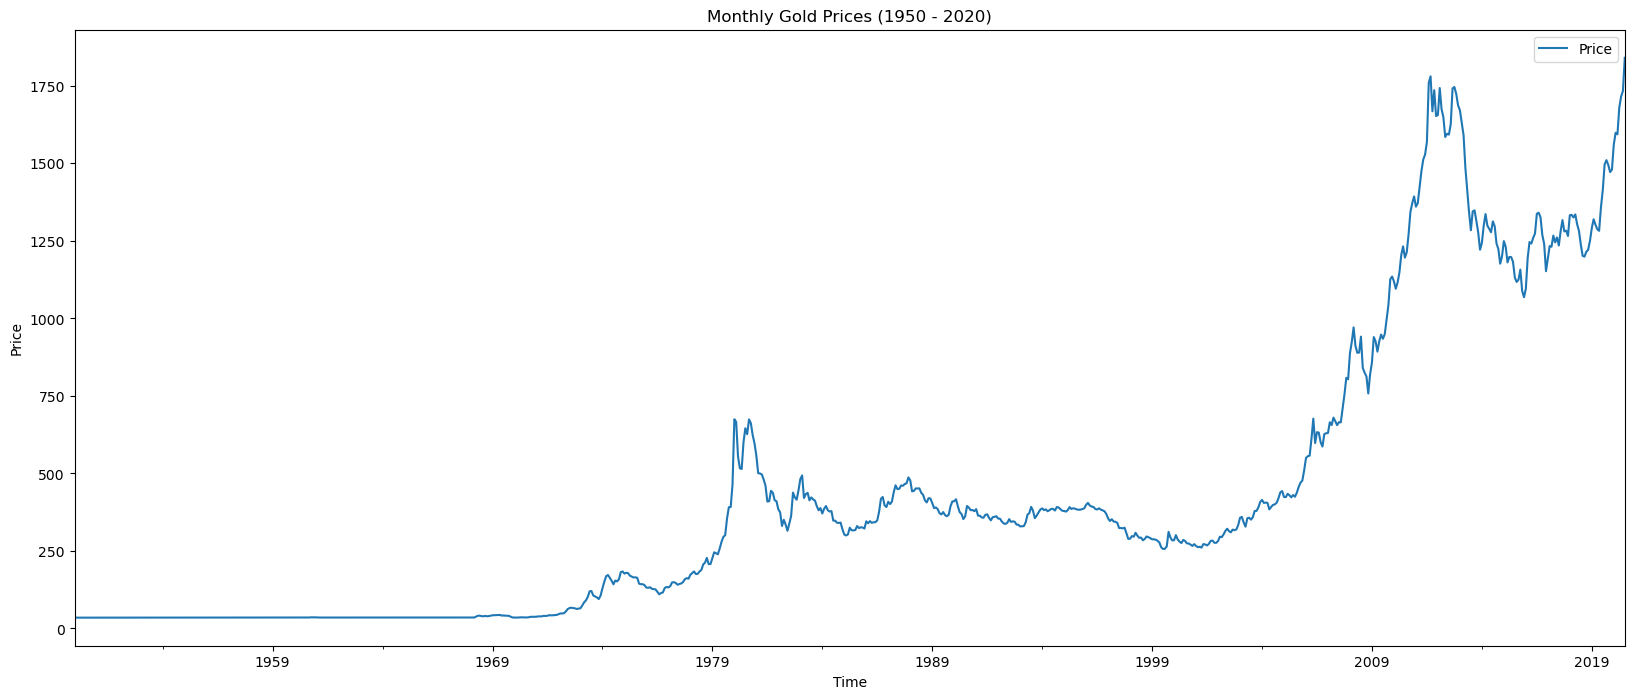

In [27]:
df.plot(figsize = (20,8))
plt.title("Monthly Gold Prices (1950 - 2020)")
plt.xlabel('Time')
plt.ylabel('Price')

In [28]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


Text(0, 0.5, 'price')

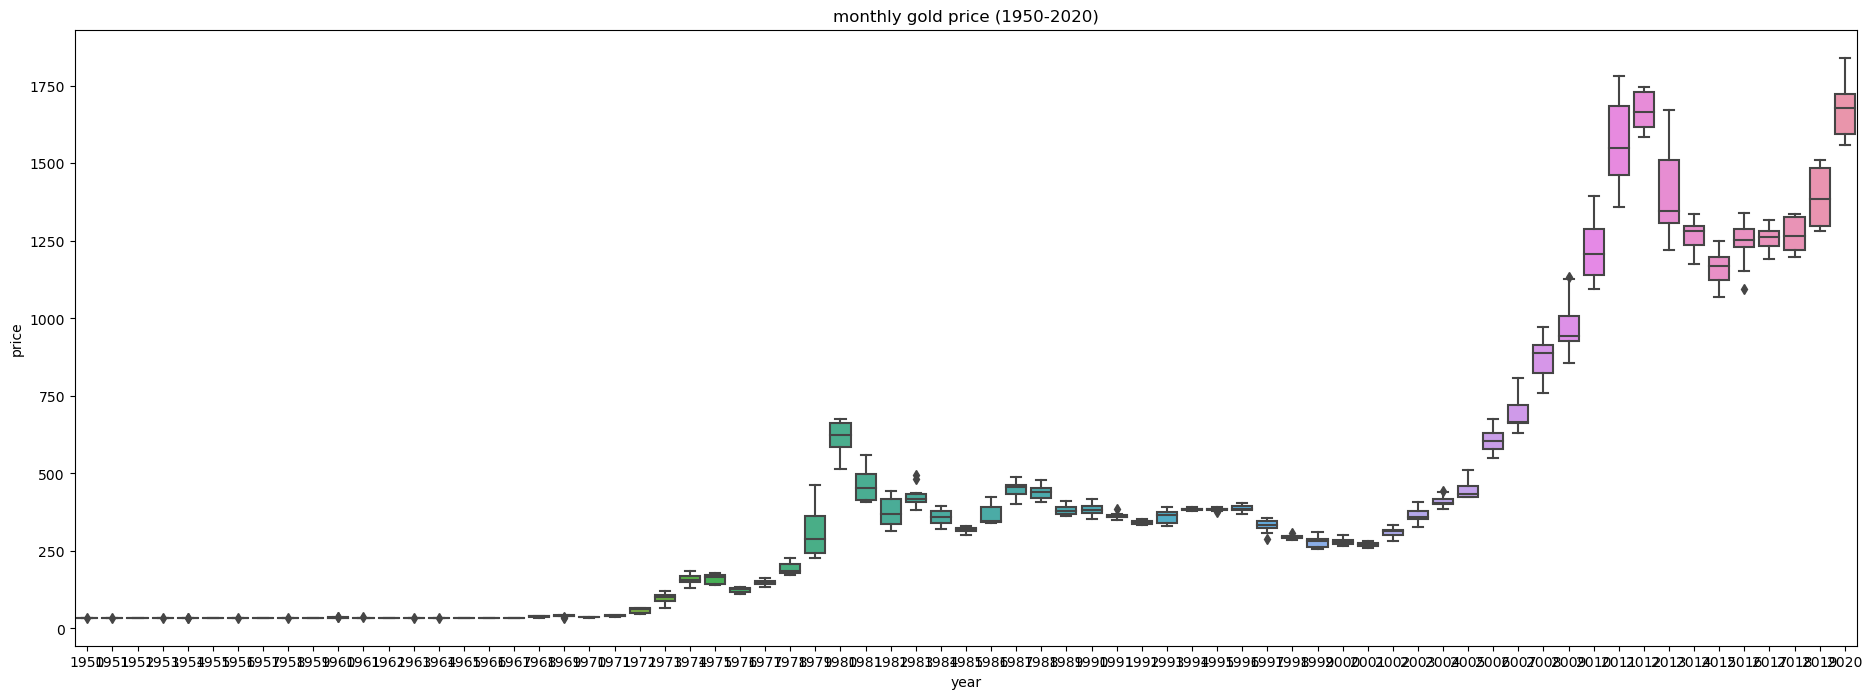

In [31]:
_, ax = plt.subplots(figsize = (23,8))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax=ax)
plt.title('monthly gold price (1950-2020)')
plt.xlabel('year')
plt.ylabel('price')

Text(0, 0.5, 'Price')

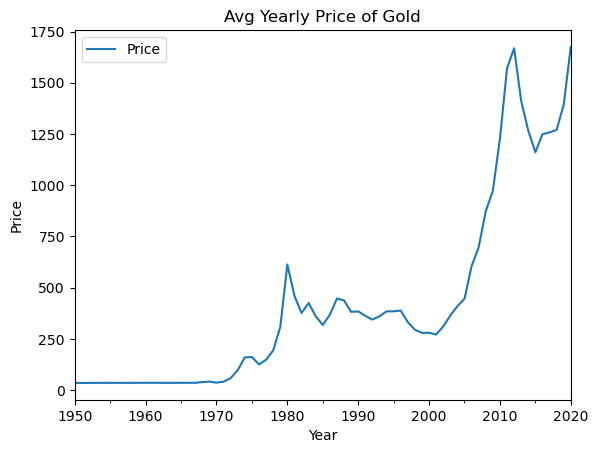

In [32]:
avg_yearly_price = df.resample('A').mean()
avg_yearly_price.plot();
plt.title('Avg Yearly Price of Gold')
plt.xlabel('Year')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

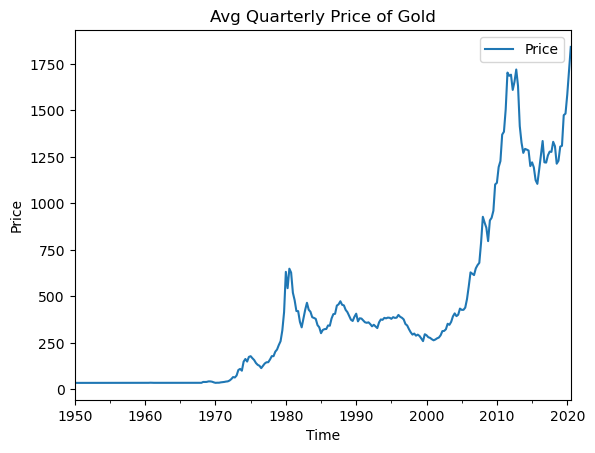

In [33]:
avg_quarterly_price = df.resample('Q').mean()
avg_quarterly_price.plot();
plt.title('Avg Quarterly Price of Gold')
plt.xlabel('Time')
plt.ylabel('Price')

In [35]:
df1 = df.groupby(df.index.year).mean().rename(columns = {'Price':'Mean'})
df1 = df1.merge(df.groupby(df.index.year).std().rename(columns = {'Price':'STD'}), left_index = True, right_index = True)
df1['Cov_pct'] = ((df1['STD']/df1['Mean'])*100).round(2)
df1.head()

,Mean,STD,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


Text(0, 0.5, 'cv in %')

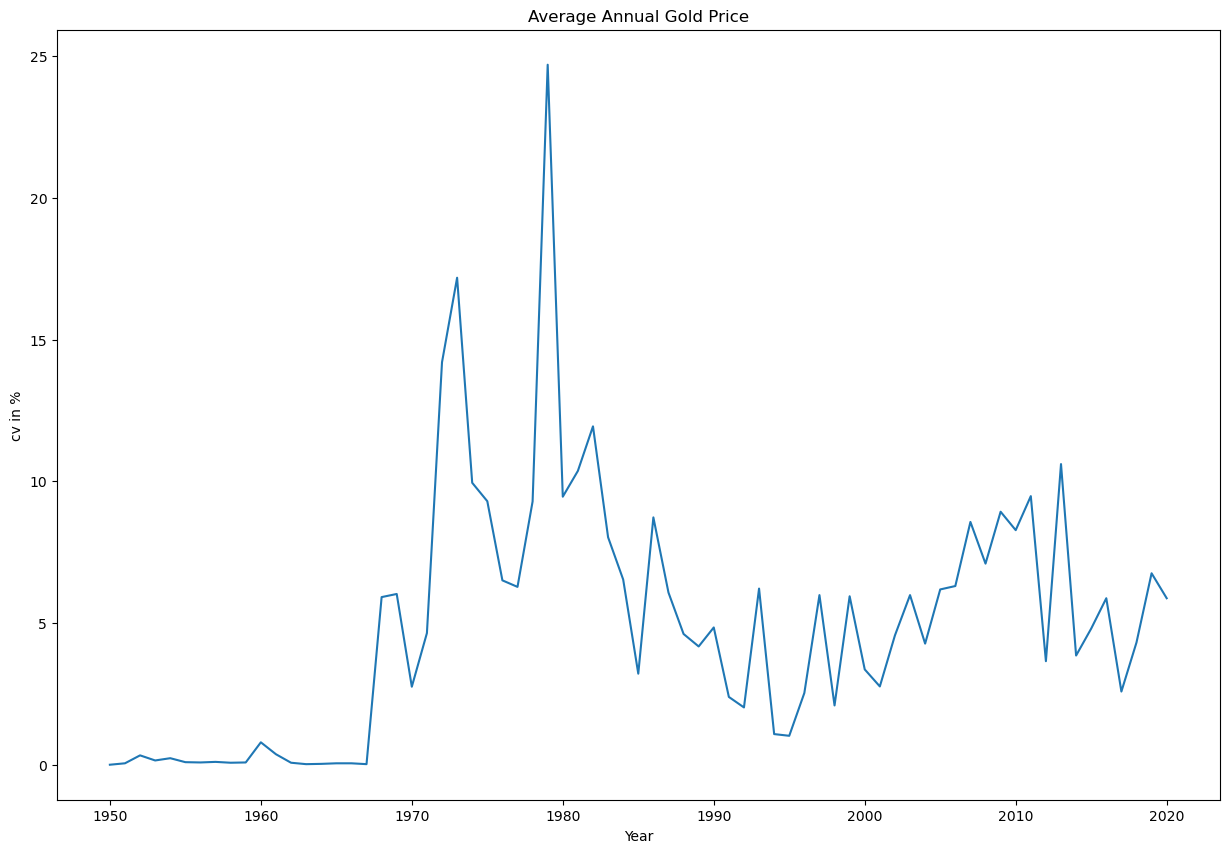

In [36]:
fig, ax = plt.subplots(figsize = (15,10))
df1['Cov_pct'].plot();
plt.title("Average Annual Gold Price")
plt.xlabel("Year")
plt.ylabel("cv in %")

In [37]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [39]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


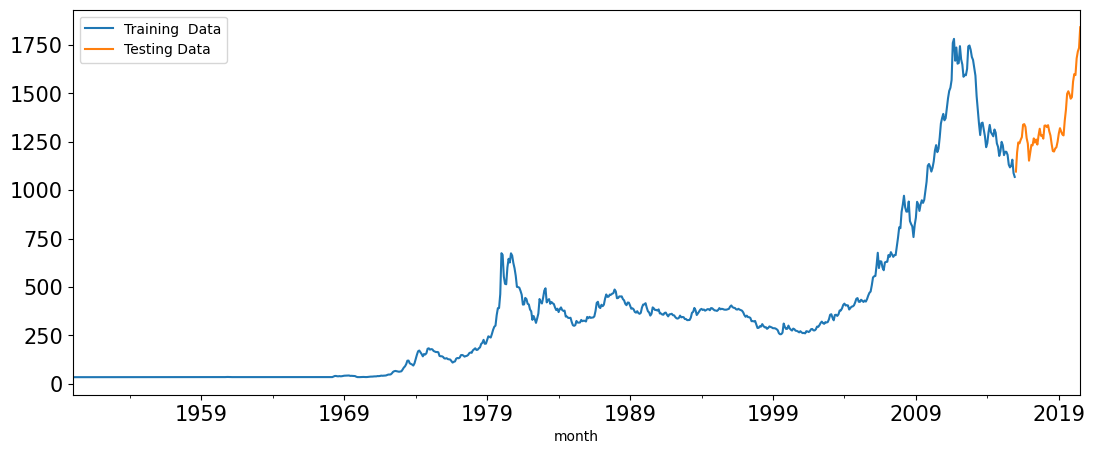

In [43]:
train['Price'].plot(figsize=(13,5), fontsize = 15)
test['Price'].plot(figsize=(13,5), fontsize = 15)
plt.legend(['Training  Data', 'Testing Data'])

In [45]:
train_time = [i + 1 for i in range(len(train))]
test_time = [i + len(train) + 1 for i in range(len(test))]
len(train_time),len(test_time)

(792, 55)

In [47]:
LRTrain = train.copy()
LRTest = test.copy()

In [48]:
LRTrain['Time'] = train_time
LRTest['Time'] = test_time

In [52]:
lr = LinearRegression()
lr.fit(LRTrain[['Time']], LRTrain['Price'].values)

LinearRegression()

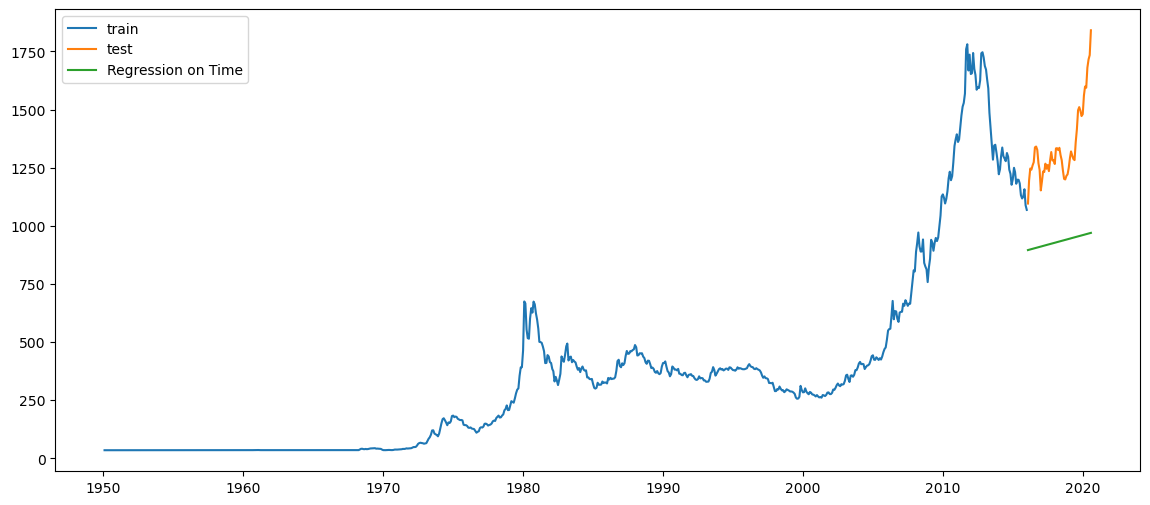

In [56]:
Test_Model_1 = lr.predict(LRTest[["Time"]])
LRTest['Forecast'] = Test_Model_1

plt.figure(figsize = (14,6))
plt.plot(train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(LRTest['Forecast'], label = 'Regression on Time')
plt.legend(loc = 'best')

In [57]:
def mape(actual, pred):
    return round((np.mean(abs(actual - pred)/actual))*100,2) 

In [68]:
mape_model_1_test = mape(test['Price'].values, Test_Model_1)
print(mape_model_1_test,'%')

29.76 %


In [69]:
results = pd.DataFrame({"Test Mape %": [mape_model_1_test]}, index = ['Regression On Time'])
results

,Test Mape %
Regression On Time,29.76


In [62]:
Naive_test= test.copy()
Naive_train = train.copy()

In [63]:
Naive_test['Naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['Naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: Naive, dtype: float64

Text(0.5, 1.0, 'Naive Forecast')

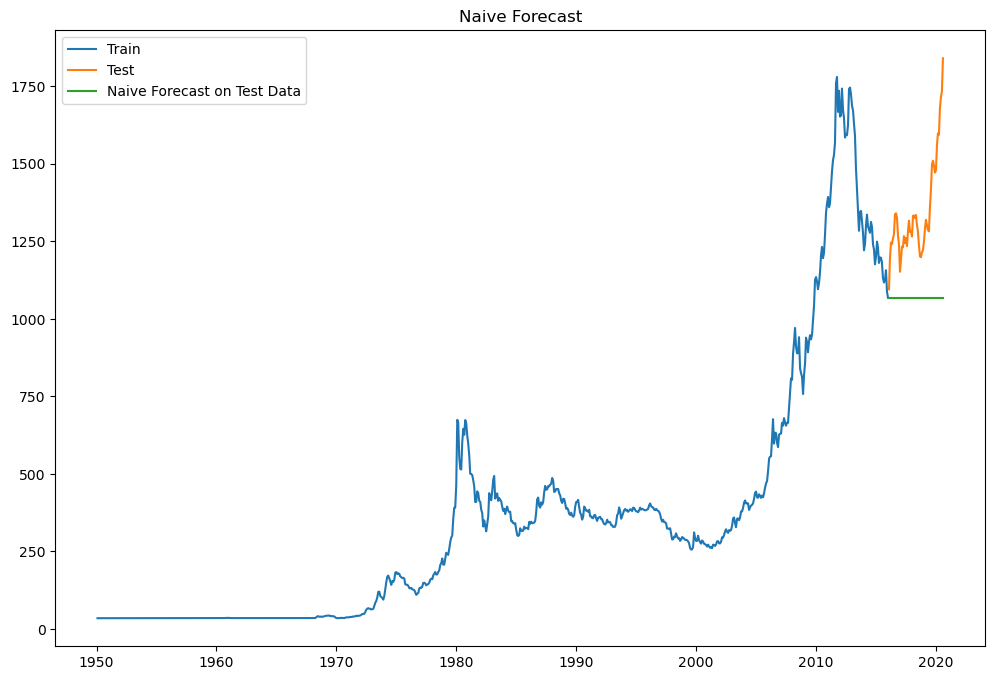

In [64]:
plt.figure(figsize = (12,8))
plt.plot(Naive_train['Price'], label = 'Train')
plt.plot(test["Price"], label = 'Test')
plt.plot(Naive_test['Naive'], label = 'Naive Forecast on Test Data')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

In [67]:
mape_model_2_test = mape(test['Price'].values, Naive_test['Naive'].values)
print(mape_model_2_test,"%")

19.38 %


In [71]:
results2 = pd.DataFrame({"Test Mape %": [mape_model_2_test]}, index = ['Naive Model'])
results = pd.concat([results,results2])
results

,Test Mape %
Regression On Time,29.76
Naive Model,19.38


In [75]:
Final_Model = ExponentialSmoothing(df,
                                   trend = 'additive',
                                   seasonal = 'additive').fit(smoothing_level = 0.4,
                                                              smoothing_trend = 0.3,
                                                              smoothing_seasonal = 0.6)

In [76]:
mape_model_final = mape(df['Price'].values, Final_Model.fittedvalues)
print(mape_model_final,"%")

17.24 %


In [77]:
predictions = Final_Model.forecast(steps = len(test))

In [79]:
pred_df = pd.DataFrame({'lower_ci': predictions - 1.96 * np.std(Final_Model.resid, ddof = 1), 
                         'Prediction': predictions,
                        'upper_ci': predictions + 1.96 * np.std(Final_Model.resid, ddof = 1)})
pred_df.head()

,lower_ci,Prediction,upper_ci
2020-08-31,1684.713703,1792.864676,1901.015650
2020-09-30,1615.291065,1723.442039,1831.593012
2020-10-31,1538.543199,1646.694172,1754.845146
2020-11-30,1476.724385,1584.875359,1693.026332
2020-12-31,1459.285045,1567.436019,1675.586992


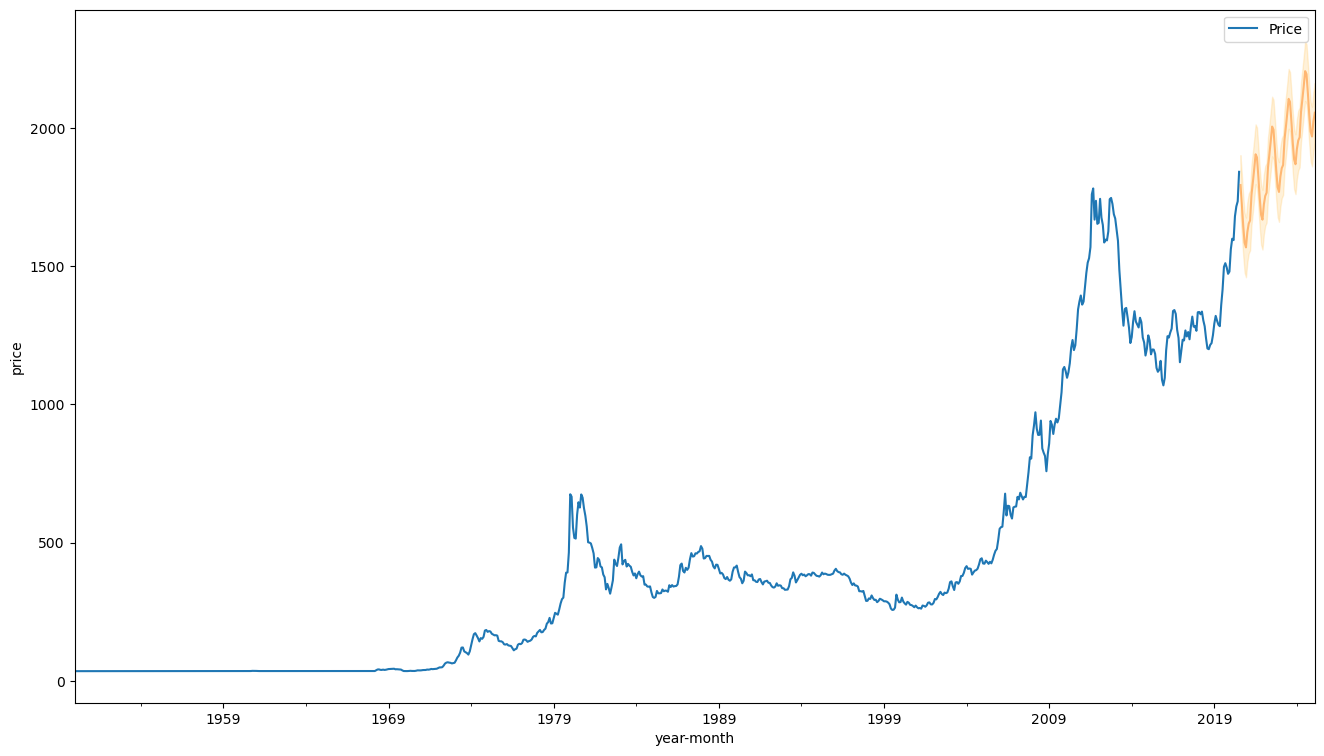

In [82]:
axis = df.plot(label = 'Actual', figsize = (16,9))
pred_df['Prediction'].plot(ax = axis, label = 'forecast', alpha = 0.5)
axis.fill_between(pred_df.index, pred_df['lower_ci'], pred_df['upper_ci'], color= 'orange', alpha = .15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.show()